## Preparation

Welcome to the Vectice tutorial notebook!


Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice Python library:
- Dataset versions
- Model versions
- Runs and lineage

For more information on the tutorial, please refer to the "Vectice Tutorial Page" inside the app.



### Install Vectice

In [ ]:
## Requirements
!pip3 install --q s3fs
!pip3 install --q --upgrade pandas
#Install Vectice Python library 
# In this tutorial we will do code versioning using github, we also support gitlab
# and bitbucket: !pip install -q "vectice[github, gitlab, bitbucket]"
!pip3 install --q vectice[github]

In [11]:
#Verify if Vectice python library was installed
!pip3 show vectice

Name: vectice
Version: 0.20.0
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: python-dotenv, requests
Required-by: 


### Get the data from S3

We are going to load data stored in Amazon S3, that is provided by Vectice for this tutorial.


- If you're using Sagemaker studio with access to your data on S3 or if your data is public, you can read it by using **pd.read_csv(URI S3 of your file)**
- If you're using Sagemaker studio without access to your data on S3, you should authenticate to be able to retrieve your data from S3. For more information, check the [documentation](https://doc.vectice.com/)

In [91]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('s3://vectice-examples/Tutorial/kc_house_data_cleaned.csv')

# Run head to make sure the data was loaded properly
df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice Python library.

In [99]:
#Import the Vectice library
from vectice import Vectice
from vectice.models import JobType
from vectice.entity.model import ModelType
import logging
logging.basicConfig(level=logging.INFO)

# Specify the API endpoint for Vectice. This shouldn't change.
os.environ['VECTICE_API_ENDPOINT']= "beta.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "API Tokens" tab in your workspace
# Copy and paste your API key here
os.environ['VECTICE_API_TOKEN'] = "q0Ke4JnjX.4rQPGZAVpkNg1dzb3864q0Ke4JnjXR729MaoYyJDm5xOLEvlW3"

# Next, you need to specify the tutorial project where you will run this notebook using a 
# "Project Token". You can find the "Project Token" under the "Settings" tab of your project.

# Copy and paste your Project Token here
vectice = Vectice(project_token="z3j5bB2JCXqEk6WBYlEx")


INFO:vectice.auth:Vectice: Refreshing token... 
INFO:vectice.auth:Success!
INFO:vectice.auth:Vectice: Validating project token... 
INFO:vectice.auth:The entered token is OK, and allows you to work on the 'Sagemaker: Predicting house prices in King County' Project, part of the 'Sample - Everyone' Workspace


### Split dataset into training and testing

Let's split the dataset into train and test sets and save them in Amazon S3.
(The Amazon S3 code has been commented out as the data has already been generated.) There is already a dataset created inside the tutorial project we are going to reuse, and create a new version. You can also create directly a new dataset from your notebook:
- Without a connection: **vectice.create_dataset(dataset_name="dataset name",
data_properties=[("key", "prop"), ("key2", "prop2"),])**
- Using a connection: **vectice.create_dataset_with_connection_id()** or **vectice.create_dataset_with_connection_name()**. You can get the connection name and id of the connections you have in your workspace by calling **vectice.list_connections()**


We can get the list of the datasets existing in our project by calling **vectice.list_datasets()**

In [102]:
vectice.list_datasets().list

[DatasetOutput(id=532, pattern='*', isPatternBase=False, createdDate='2021-12-21T15:04:46.917Z', updatedDate='2021-12-21T15:05:18.781Z', deletedDate=None, connectionId=149, createdByUserId=98, projectId=273, workspaceId=99, version=2, name='S3_kc_house_data', description=''),
 DatasetOutput(id=527, pattern='*', isPatternBase=False, createdDate='2021-12-21T13:47:41.259Z', updatedDate='2021-12-21T13:47:41.320Z', deletedDate=None, connectionId=None, createdByUserId=98, projectId=273, workspaceId=99, version=1, name='S3_test_cleaned_kc_house_data', description=None),
 DatasetOutput(id=526, pattern='*', isPatternBase=False, createdDate='2021-12-21T13:47:41.240Z', updatedDate='2021-12-21T13:47:41.319Z', deletedDate=None, connectionId=None, createdByUserId=98, projectId=273, workspaceId=99, version=1, name='S3_train_cleaned_kc_house_data', description=None),
 DatasetOutput(id=525, pattern='*', isPatternBase=False, createdDate='2021-12-21T13:47:40.881Z', updatedDate='2021-12-21T13:47:40.936Z',

In [94]:
import string
from math import sqrt

# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression


In [95]:
# Create a dataset version to use as input of our run. 
#**vectice.create_dataset_version()** creates the dataset and the first version of this dataset automatically if
## the dataset doesn't exist in your project.
input_ds_version = vectice.create_dataset_version().with_parent_name("S3_cleaned_kc_house_data").with_properties([('cleaned dataset version property', 'value')])


# We create a code version in order to be able to track the source code from Vectice
input_code = Vectice.create_code_version_with_github_uri("https://github.com/vectice/vectice-examples",
                        "Notebooks/Vanilla/Tutorial/Tutorial_Modelling_All_Sagemaker.ipynb") 

# Each execution for a given job is called a run. When creating a run you need to specify:
# 1) a job name (mandatory)
# 2) a job type (optional)
# 3) a run name (optional)
# Job names, job types and run names are useful to group and search runs in the Vectice UI.
# For this run, we will use the job name "S3_80/20 Split", the job type "PREPARATION" and the run name "Data-Cleaning"
# You can have multiple runs with the same job name
vectice.create_run("S3_80/20 Split", JobType.PREPARATION, "Data-Preparation").with_properties([('property', 'value'), ('property2', 'value2')])
with vectice.start_run(inputs=[input_ds_version,input_code]) as run:

# We will use an 80/20 split to prepare the data
    test_size = 0.2

# We will set the random seed so we always generate the same split.
    random_state = 42

    train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in Amazon S3, 
# because we already generated the data for you.
# We left the code below for convenience, in case you want to use your own credentials and S3 bucket.
# train.to_csv (r's3://vectice-examples/Tutorial/train_cleaned_kc_house_data.csv', index = False, header = True)
# test.to_csv (r's3://vectice-examples/Tutorial/test_cleaned_kc_house_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
    X = df.drop("price", axis=1).values
    y = df["price"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's create versions of the training and testing dataset.
    train_ds_version = vectice.create_dataset_version().with_parent_name("S3_train_cleaned_kc_house_data").with_properties([('training dataset version property', 'value')])
    test_ds_version = vectice.create_dataset_version().with_parent_name("S3_test_cleaned_kc_house_data").with_properties([('testing dataset version property', 'value')])

# Attach the output datasets to the run.
    run.add_outputs(outputs=[train_ds_version,test_ds_version])

# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train


array([[ 4.00000e+00,  3.00000e+00,  3.61000e+03, ..., -1.22342e+02,
         3.56800e+03,  1.89480e+04],
       [ 3.00000e+00,  2.00000e+00,  2.08000e+03, ..., -1.22285e+02,
         1.92000e+03,  7.00000e+03],
       [ 4.00000e+00,  2.50000e+00,  2.09000e+03, ..., -1.22221e+02,
         1.51000e+03,  7.40200e+03],
       ...,
       [ 3.00000e+00,  1.00000e+00,  1.46000e+03, ..., -1.22191e+02,
         1.15000e+03,  5.92600e+03],
       [ 3.00000e+00,  2.25000e+00,  1.62000e+03, ..., -1.22137e+02,
         1.60000e+03,  7.91000e+03],
       [ 4.00000e+00,  3.50000e+00,  3.38000e+03, ..., -1.22379e+02,
         2.22000e+03,  8.33000e+03]])

#### ds = vectice.create_dataset_version().with_parent_name("S3_test_cleaned_kc_house_data")
vectice.create_run("t")
vectice.start_run(inputs=[ds])
vectice.end_run()

## Modeling

We can get the list of the models existing in the project by calling **vectice.list_models()**

In [103]:
vectice.list_models().list

[ModelOutput(createdDate='2021-12-21T14:09:57.946Z', updatedDate='2021-12-21T14:18:55.743Z', version=2, id=194, authorId=98, workspaceId=99, projectId=273, repository=None, deletedDate=None, name='S3_Regressor', type='REGRESSION', description='Model description')]

### Linear regression model

First, we will do a basic Linear Regression and observe the baseline accuracy metrics.

In [44]:
# Each execution for a given job is called a run, for LR we will only do one run.
# Setting a job's name is mandatory when starting a run 
# and is useful to group and search runs in the Vectice UI.

# Linear regression model training
vectice.create_run("S3_LR-Model", JobType.TRAINING, "Linear Regression").with_properties([('property', 'value'), ('property2', 'value2')])
with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    lr_rg = LinearRegression()
    lr_rg.fit(X_train, y_train)
    lr_pred = lr_rg.predict(X_test)

# Evaluate Metrics
    MAE = mean_absolute_error(lr_pred, y_test)
    RMSE = sqrt(mean_squared_error(lr_pred, y_test))

    print("Root Mean Squared Error: ", RMSE)
    print("Mean Absolute Error: ", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
## Here we use with_user_version() to create a new model version. You can provide a version name for your model version.
# An error will be thrown if the given user version already exists. If you don't provide a version name,
# the version name will be "Version"+"the version number".
    model_version = vectice.create_model_version().with_parent_name("S3_Regressor").with_algorithm("Linear Regression").with_type(ModelType.REGRESSION).with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_user_version()

    run.add_outputs(outputs=[model_version])


Root Mean Squared Error:  154238.92042968297
Mean Absolute Error:  108422.20300316534


We can update a model's type or description by using **vectice.update_model()**

In [45]:
vectice.update_model(parent_name="S3_Regressor", model_type=ModelType.REGRESSION, description="Model description")

INFO:Vectice:Model: 'S3_Regressor' has been updated


### Decision tree model

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

Root Mean Squared Error: 146549.97417133604
Mean Absolute Error: 96923.7107879853


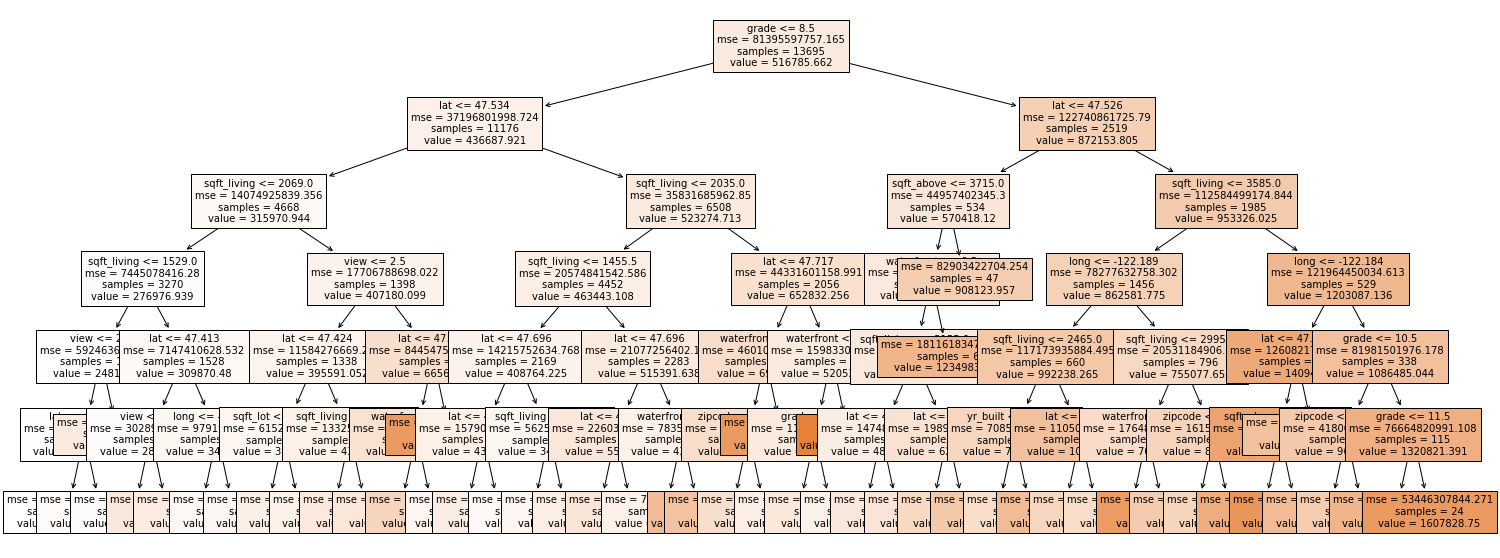

In [48]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
# The model versions you created will show up in the Vectice UI as new versions 
# of the "Regressor" Model. You can easily compare them from there.
tree_depth = 6

vectice.create_run("S3_DT-Model", JobType.TRAINING, "DT-6").with_properties([('property', 'value'), ('property2', 'value2')])

with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
    dtr.fit(X_train,y_train)
    dtr_pred = dtr.predict(X_test) 

    data_feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
                      'long', 'sqft_living15', 'sqft_lot15']

# Visualize the Decision Tree Model
    plt.figure(figsize=(25, 10))
    plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)
    plt.savefig("DecisionTree_6.png")
  ## We can attach the decision tree plot to the model version by using .with_attachments([Attachments])
    MAE = mean_absolute_error(dtr_pred, y_test)
    RMSE = sqrt(mean_squared_error(dtr_pred, y_test))

    print("Root Mean Squared Error:", RMSE)
    print("Mean Absolute Error:", MAE)
# Here we use with_user_version() to create a new model version. You can provide a version name 
# for your model version. An error will be thrown if the given user
# version already exists. If you don't provide a version name, the version name will be 
# "Version"+"the version number".
    model_version = vectice.create_model_version().with_parent_name("S3_Regressor").with_algorithm("Decision Tree").with_type(ModelType.REGRESSION).with_property("Tree Depth",str(tree_depth)).with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_attachments(["DecisionTree_6.png"]).with_user_version()

    run.add_outputs(outputs=[model_version])

### Random forest model

Let's use the Random Forest Regression and do some hyper-parameter tuning on it.

In [60]:
# You can modify the parameters below and execute multiple runs to train 
# different versions of RF model.
nb_trees = 60
min_samples = 60

vectice.create_run("S3_RF-Model", JobType.TRAINING, "RandomForest-3").with_properties([('property', 'value'), ('property2', 'value2')])

with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    rf_regressor = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_samples)
    rf_regressor.fit(X_train, y_train)
    rf_regressor.score(X_test, y_test)
    rf_regressor_pred = rf_regressor.predict(X_test)

    MAE = mean_absolute_error(rf_regressor_pred, y_test)
    RMSE = sqrt(mean_squared_error(rf_regressor_pred, y_test))

    print("Root Mean Squared Error:", RMSE)
    print("Mean Absolute Error:", MAE)

# Here's an alternative version to declare metrics
    metrics = [("RMSE",RMSE),
           ("MAE",MAE)]
## Here we use with_user_version() to create a new model version. You can provide a version
## name for your model version. An error will be thrown if the given user
## version already exists. If you don't provide a version name, the version name will be "Version"+"the version number".
    model_version = vectice.create_model_version().with_parent_name("S3_Regressor").with_algorithm("Random Forest").with_type(ModelType.REGRESSION).with_property("nb_trees",str(nb_trees)).with_property("min_samples",str(min_samples)).with_metrics(metrics).with_user_version()

    run.add_outputs(outputs=[model_version])

Root Mean Squared Error: 133302.4679001312
Mean Absolute Error: 81831.54960037177


In [61]:
vectice.list_models().list

[ModelOutput(createdDate='2021-12-21T14:09:57.946Z', updatedDate='2021-12-21T14:17:50.918Z', version=2, id=194, authorId=98, workspaceId=99, projectId=273, repository=None, deletedDate=None, name='S3_Regressor', type='REGRESSION', description='Model description')]

You can also retrieve all the model versions you created in previous runs, for offline analysis and understanding in more details what's driving the models performance.

In [82]:
df = vectice.list_model_versions_dataframe(194)
df

createdDate,name,versionNumber,status,algorithmName,isStarred,MAE,RMSE,Tree Depth,min_samples,nb_trees
2021-12-21T14:17:50.918Z,Version 7,7,EXPERIMENTATION,Random Forest,False,81831.54960037177,133302.4679001312,nan,60,60
2021-12-21T14:17:40.994Z,Version 6,6,STAGING,Random Forest,False,75910.49908873613,125199.07297567555,nan,30,60
2021-12-21T14:17:30.881Z,Version 5,5,EXPERIMENTATION,Random Forest,False,76515.32282617783,125899.52776290949,nan,30,30
2021-12-21T14:13:53.179Z,Version 4,4,PRODUCTION,Decision Tree,True,96923.7107879853,146549.97417133604,6,nan,nan
2021-12-21T14:10:53.830Z,Version 3,3,EXPERIMENTATION,Decision Tree,False,112088.19615621041,165154.56185163363,4,nan,nan
2021-12-21T14:10:35.367Z,Version 2,2,EXPERIMENTATION,Decision Tree,False,141828.93787447334,203124.4326714488,2,nan,nan
2021-12-21T14:09:57.981Z,Version 1,1,EXPERIMENTATION,Linear Regression,False,108422.20300316534,154238.92042968297,nan,nan,nan


We can see that the Random Forest Regressor model gives the lowest error and should be the preferred approach despite the complexity of the algorithm. Let's get the list of features' importance to discuss which variables are influencing the model the most.

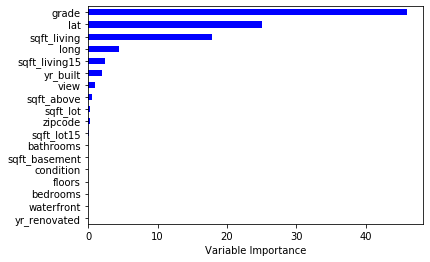

In [70]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
           'long', 'sqft_living15', 'sqft_lot15']

importance = pd.DataFrame({'Importance': rf_regressor.feature_importances_ * 100}, index=columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="b")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None


Thank you and congratulations! You have succesfully completed the notebook part of the tutorial.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice Python library. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice Python library and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this tutorial. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
